IMPLEMENTATION
- LSTM/RNN AND THEN TRANSFORMERS INSTEAD RNN
- MODIFY THE GENERATOR AND INTRODUCE A WASSERSTEIN + GRADIENT PENALTY
- IMPLEMENTATION IN THE ORIGINAL TIME GAN CODE

In [1]:
# ------------------------------------------------------------
# ✅ CELDA 1 — Carga real de señales + normalización + ventanas
# ------------------------------------------------------------

import numpy as np
import scipy.io as sio
import glob
from lib.data_preprocess import MinMax_Scaler, real_data_loading

# Ruta donde están los .mat
data_dir = r"C:\Users\Dario\Desktop\ThesiS JBP\Data"
file_list = sorted(glob.glob(f"{data_dir}/signals_for_GAN_*.mat"))

print("Archivos encontrados:")
for f in file_list:
    print("  ", f)

if len(file_list) == 0:
    raise FileNotFoundError("❌ No se encontraron archivos signals_for_GAN_*.mat")

# ------------------------------------------------------------
# 🔹 1) Concatenar toda tu señal cruda en un solo array
# ------------------------------------------------------------
all_data = []
for file in file_list:
    mat = sio.loadmat(file)
    data = mat['data_all']   # shape [N, 6]
    all_data.append(data)

data_global = np.vstack(all_data)   # [total_muestras, 6]
print(f"\n✔ Señal total concatenada: {data_global.shape}")

# ------------------------------------------------------------
# 🔹 2) Normalizar TODO globalmente (muy importante)
# ------------------------------------------------------------
norm_data, scaler = MinMax_Scaler(data_global)
print("✔ Normalización global con MinMaxScaler aplicada")

# ------------------------------------------------------------
# 🔹 3) Crear ventanas con sliding-window (seguro y generalizado)
# ------------------------------------------------------------
seq_len = 256        # tamaño fijo de ventana
step = 128           # overlap 50% → recomendado

ori_data = real_data_loading(norm_data, seq_len, step)

print(f"\n✔ Total de ventanas creadas: {len(ori_data)}")
print(f"✔ Forma de una ventana: {ori_data[0].shape}")  # (256, 6)


Archivos encontrados:
   C:\Users\Dario\Desktop\ThesiS JBP\Data\signals_for_GAN_01.mat

✔ Señal total concatenada: (6144001, 6)
✔ Normalización global con MinMaxScaler aplicada
✅ Created 6143745 sequences of length 256

✔ Total de ventanas creadas: 6143745
✔ Forma de una ventana: (256, 6)


In [ ]:
from options_TGAN import Options
from lib.TimeGAN import TimeGAN

# 1. Options
opt = Options().parse()

# 2. Settings
opt.seq_len = seq_len            # 256, mismo de arriba
opt.iteration = 1000             # pocas iteraciones para probar
opt.batch_size = 32              # batch pequeño
opt.n_critic = 5                 # ya lo definiste para WGAN-GP
opt.gp_lambda = 10.0             # peso del gradient penalty
opt.name = "TimeGAN_real_small"  # nombre del experimento (carpeta de salida)

# 3. Create model
model = TimeGAN(opt, ori_data)

# 4. Train
model.train()


[INFO] Adjusted opt.z_dim to match data feature size: 6
[DEBUG] Loss this iteration: 0.077676
Encoder training step: 0/1000
[DEBUG] Loss this iteration: 0.048913
Encoder training step: 1/1000
[DEBUG] Loss this iteration: 0.023869
Encoder training step: 2/1000
[DEBUG] Loss this iteration: 0.017437
Encoder training step: 3/1000
[DEBUG] Loss this iteration: 0.019619
Encoder training step: 4/1000
[DEBUG] Loss this iteration: 0.017665
Encoder training step: 5/1000
[DEBUG] Loss this iteration: 0.017516
Encoder training step: 6/1000
[DEBUG] Loss this iteration: 0.021335
Encoder training step: 7/1000
[DEBUG] Loss this iteration: 0.018692
Encoder training step: 8/1000
[DEBUG] Loss this iteration: 0.017317
Encoder training step: 9/1000
[DEBUG] Loss this iteration: 0.016043
Encoder training step: 10/1000
[DEBUG] Loss this iteration: 0.020323
Encoder training step: 11/1000
[DEBUG] Loss this iteration: 0.017608
Encoder training step: 12/1000
[DEBUG] Loss this iteration: 0.017456
Encoder training st

In [9]:
from generation_TGAN import safe_generation
generated_data = safe_generation(model, num_samples=50, batch_size=64)



🧩 Generating 50 samples in 1 batches of 64...
  ✅ Batch 1/1 generated (50 samples)


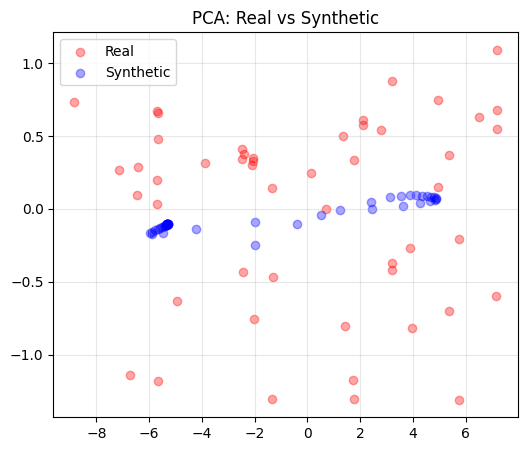

🌀 Ejecutando t-SNE (puede tardar 20–40s)...


c:\Users\Dario\Desktop\ThesiS JBP\jordan_venv\lib\site-packages\sklearn\manifold\_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


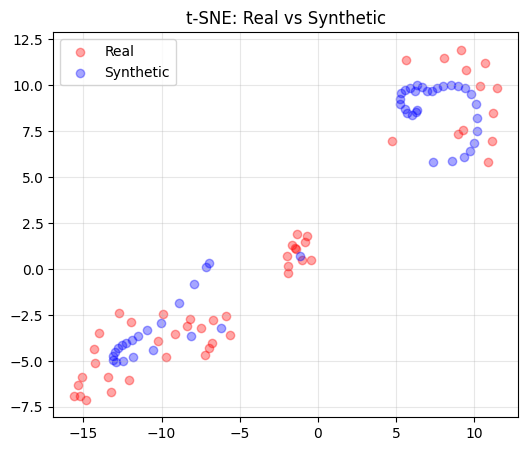

In [11]:
n_vis = 1000  # target

n_real = min(n_vis, len(ori_data))
n_fake = min(n_vis, len(generated_data))

idx_real = np.random.choice(len(ori_data), n_real, replace=False)
idx_fake = np.random.choice(len(generated_data), n_fake, replace=False)

ori_vis = [ori_data[i] for i in idx_real]
gen_vis = [generated_data[i] for i in idx_fake]

from visualization_TGAN import visualization

visualization(ori_vis, gen_vis, 'pca')
visualization(ori_vis, gen_vis, 'tsne')



In [ ]:
# Modification 1 : 
# Discriminator - Change the discriminator to WGAN-GP, delete Spectral Norm, no sigmoid  and add layernorm. 
# We did this in ordert to avoid saturation and collapse in discriminator. Normal TIMEGAN uses sigmoid + BCE  to classify real/fake, is classifficator not critic regression.
# We delete the sigmoid to get real scores, dsicriminatori not classify now estiamte Wasserstein distance, delete spectral norm, and add layernorm to give stability.
# We did this change because BCE tends to collapse, WGAN-GP produces smooth gradients, more stable. Is ideal for vibrations .

# Modification 2: 
# We dont include LSTM , instead we add LayerNorm to all sub networks (5 networks also modified its forward functions accordign to this) in order to reduce the instability and collapse, specially in signals viration.
#TimeGAN only has GRU raw, without normalziation, so high variation of activations , noise + lenght seq generates collapse and inestbaility.
# So we add LayerNorm in each GRU Encoder, Recovery, Generator, Supervisor, Discriminator. Layernorm stabilize each step of time, GRU becomes more stable wiht real noise, training smooth. Improve convergence.
# 
# 
#  Modification 3: 
# Add Gradient Penalty TimeGAN, and reeplce all the backward_d of discriminator to WGAN-GP. 
# Here th timegan original used the BCE which measures probabilities true or false, and have gradients 0 o 1. So we use WGAN, , and by force GRADIENT PENALTY.
# WGAN measures the real distance between distributions, not probailities. Avoid collapse, is more stable for continuous signals, and and produce smooth training.

# Modification 4:
# Trainning Loop WGAN, in TIMEGAN it train 1:1 G y D, is bad for WGAN generates poor gradients. New modification in training loop we train the critic 5 times more than generator.
# This is better because , critic is strong, gradients are high quality when send to generator. Convergence is stable.


# Modification 5 : change the real data loading indata pre processing, now it overlap 75% of information. As vibration signals change fast, is not o stable. Considering overlaping 75% we are sure will take all infroamtion, noramlly papers consider 50,75 and 90%, in order to make 
# the model learn correctly. for example if u have 1000 points a windows of 200, and failure occurs between 350-400, u will have small infromation o nly one window, but if u apply 75% , u will have 6-7 windows. so will have more relvant infroamtion. So this help to catch transitions better.BaseExceptionimprove GAN trainning , increase the number of windows 
# and dont loose important parts per window.
# Original timegan dont use overlapping, so have low windows, less transition, so bad representation of virbation. Now we use overlapping of 75%, so generate 4 times more windows, captures more information .
# so more infromatio is better cause enrich timegan.

In [6]:
# This point we modified the PCA to make multivariable comparisson . To properly compare real and synthetic sequences, you must use all variables and all time steps.
# Before visualization averaged all variables, not reliable for evaluating. now we flatten the full multivariate time-series (all variables included) so PCA and t-SNE compare complete real and generated sequences correctly

from options_TGAN import Options
from lib.TimeGAN import TimeGAN

# 1. Options
opt = Options().parse()

# 2. Set paper-style hyperparameters
opt.seq_len = seq_len            # 256
opt.lr = 1e-4                    # Learning rate paper
opt.beta1 = 0.5                  # Momentum recomend
opt.batch_size = 64              # Batch paper
opt.iteration = 100               # Iteraciones 
opt.n_critic = 5                 # WGAN-GP 
opt.gp_lambda = 10.0             # Weight penalty
opt.name = "TimeGAN_real_paper_settings"

# 3. Create model
model = TimeGAN(opt, ori_data)

# 4. Train
model.train()



[INFO] Adjusted opt.z_dim to match data feature size: 6
[DEBUG] Loss this iteration: 0.145167
Encoder training step: 0/100
[DEBUG] Loss this iteration: 0.111384
Encoder training step: 1/100
[DEBUG] Loss this iteration: 0.091704
Encoder training step: 2/100
[DEBUG] Loss this iteration: 0.061466
Encoder training step: 3/100
[DEBUG] Loss this iteration: 0.046996
Encoder training step: 4/100
[DEBUG] Loss this iteration: 0.039331
Encoder training step: 5/100
[DEBUG] Loss this iteration: 0.026369
Encoder training step: 6/100
[DEBUG] Loss this iteration: 0.018642
Encoder training step: 7/100
[DEBUG] Loss this iteration: 0.017502
Encoder training step: 8/100
[DEBUG] Loss this iteration: 0.016454
Encoder training step: 9/100
[DEBUG] Loss this iteration: 0.017662
Encoder training step: 10/100
[DEBUG] Loss this iteration: 0.018016
Encoder training step: 11/100
[DEBUG] Loss this iteration: 0.015132
Encoder training step: 12/100
[DEBUG] Loss this iteration: 0.019403
Encoder training step: 13/100
[D

In [ ]:
from generation_TGAN import safe_generation
generated_data = safe_generation(model, num_samples=50, batch_size=64)

n_vis = 5000  # target

n_real = min(n_vis, len(ori_data))
n_fake = min(n_vis, len(generated_data))

idx_real = np.random.choice(len(ori_data), n_real, replace=False)
idx_fake = np.random.choice(len(generated_data), n_fake, replace=False)

ori_vis = [ori_data[i] for i in idx_real]
gen_vis = [generated_data[i] for i in idx_fake]

from visualization_TGAN import visualization

visualization(ori_vis, gen_vis, 'pca')
visualization(ori_vis, gen_vis, 'tsne')




🧩 Generating 50 samples in 1 batches of 64...
  ✅ Batch 1/1 generated (50 samples)


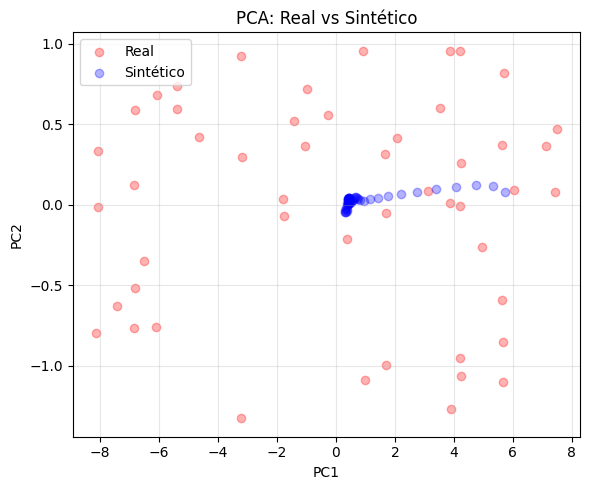

🌀 Ejecutando t-SNE (puede tardar unos segundos)...
[t-SNE] Computing 99 nearest neighbors...
[t-SNE] Indexed 100 samples in 0.000s...
[t-SNE] Computed neighbors for 100 samples in 0.031s...
[t-SNE] Computed conditional probabilities for sample 100 / 100
[t-SNE] Mean sigma: 1.271805
[t-SNE] KL divergence after 250 iterations with early exaggeration: 45.873119


c:\Users\Dario\Desktop\ThesiS JBP\jordan_venv\lib\site-packages\sklearn\manifold\_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


[t-SNE] KL divergence after 500 iterations: 0.057000


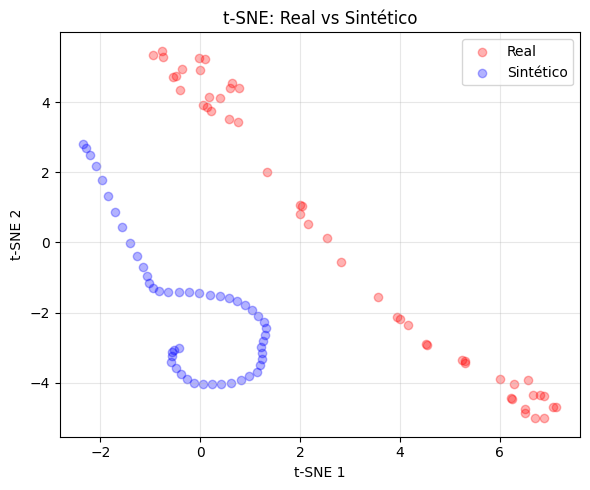